In [5]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from nltk.translate import bleu
from keras.utils import plot_model
from strsimpy.cosine import Cosine
from strsimpy.jaccard import Jaccard
from tensorflow.python.framework import ops
from strsimpy.levenshtein import Levenshtein
from keras.metrics import mean_squared_error as mse
from nltk.translate.bleu_score import SmoothingFunction
from keras.layers import Input, LSTM, Dense, Lambda, Concatenate

In [6]:
## CONFIGURATION

EPOCHS = 50
BATCH_SIZE = 64
NUM_SAMPLES = 50000
LATENT_DIMENSIONS = 32

DATA_PATH = 'fra-eng/fra.txt'

In [7]:
accepted_characters = sorted(list(" abcdefghijklmnopqrstuvwxyz1234567890"))

input_texts = []
target_texts = []

## DATA PREPROCESSING

with open(DATA_PATH, 'r', encoding = 'utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    input_text, _, _ = line.split('\t')
    input_text = input_text.lower()
    input_text = "".join(char for char in input_text if char in accepted_characters)
    target_text = '\t' + input_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)    

num_encoder_tokens = len(accepted_characters)
num_decoder_tokens = num_encoder_tokens + 2
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(accepted_characters)])
target_token_index = dict([(char, i + 2) for i, char in enumerate(accepted_characters)])
target_token_index['\t'] = 0
target_token_index['\n'] = 1
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype = 'float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = 'float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = 'float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):        
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

Number of samples: 50000
Number of unique input tokens: 37
Number of unique output tokens: 39
Max sequence length for inputs: 22
Max sequence length for outputs: 24


In [8]:
## DISCRETIZATION UTILS

def py_func(func, inp, Tout, stateful = True, name = None, grad = None):
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1e+8))
    tf.RegisterGradient(rnd_name)(grad)
    graph = tf.get_default_graph()
    with graph.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

def discrete_func(x, np_fn, name = None):
    with ops.name_scope(name, "Mysquare", [x]) as name:
        sqr_x = py_func(np_fn, [x], [tf.float32], name = name, grad = _identity_grad)  
        sqr_x[0].set_shape(x.shape)
        return sqr_x[0]

def _identity_grad(op, grad):
    return grad 

def binarize_np(x):
    a = np.zeros_like(x)
    a[x > 0.5] = 1
    return a

def Dis_Binarize():
    return Lambda(lambda x: discrete_func(x, binarize_np))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 37)     0                                            
_____________

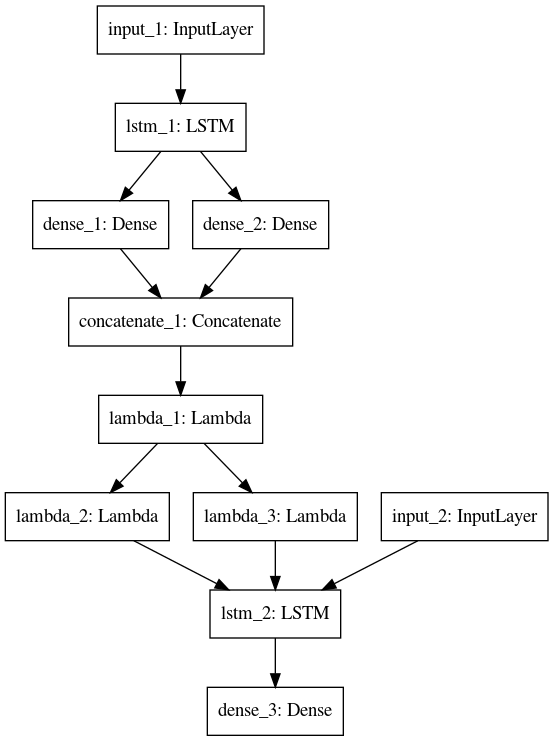

In [9]:
## AUTOENCODER MODEL DEFINITION
    
encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder_lstm = LSTM(LATENT_DIMENSIONS, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
state_h_dense = Dense(LATENT_DIMENSIONS)
state_c_dense = Dense(LATENT_DIMENSIONS)
state_h = state_h_dense(state_h)
state_c = state_c_dense(state_c)

enc_states = Concatenate(axis = 1)([state_h, state_c])
before_discretization = enc_states
enc_states = Dis_Binarize()(enc_states)
discrete_state_h = Lambda(lambda x : x[:, :LATENT_DIMENSIONS])(enc_states)
discrete_state_c = Lambda(lambda x : x[:, LATENT_DIMENSIONS:])(enc_states)
encoder_states = [discrete_state_h, discrete_state_c]
after_discretization = K.stop_gradient(enc_states)

commit_loss = mse(after_discretization, before_discretization)

decoder_inputs = Input(shape = (None, num_decoder_tokens))
decoder_lstm = LSTM(LATENT_DIMENSIONS, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.add_loss((0.2 / (2 * LATENT_DIMENSIONS)) * commit_loss)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()
plot_model(model)

In [6]:
## TRAINING (Done once per configuration)

model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2)
model.save_weights('./model_weights/training_quantized/s2s_' + str(EPOCHS) + "_" + str(BATCH_SIZE) + "_" + str(NUM_SAMPLES) + "_" + str(LATENT_DIMENSIONS) + ".h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 20s 492us/step - loss: 2.1698 - accuracy: 0.4367 - val_loss: 2.4192 - val_accuracy: 0.3427
Epoch 2/50
40000/40000 [==============================] - 16s 393us/step - loss: 1.6521 - accuracy: 0.5500 - val_loss: 2.1374 - val_accuracy: 0.4279
Epoch 3/50
40000/40000 [==============================] - 16s 396us/step - loss: 1.5369 - accuracy: 0.5905 - val_loss: 2.1123 - val_accuracy: 0.4601
Epoch 4/50
40000/40000 [==============================] - 16s 389us/step - loss: 1.4913 - accuracy: 0.6125 - val_loss: 2.1088 - val_accuracy: 0.4757
Epoch 5/50
40000/40000 [==============================] - 16s 395us/step - loss: 1.4567 - accuracy: 0.6274 - val_loss: 2.1083 - val_accuracy: 0.4907
Epoch 6/50
40000/40000 [==============================] - 16s 392us/step - loss: 1.4441 - accuracy: 0.6393 - v

In [10]:
## LOADING PRETRAINED WEIGHTS

model.load_weights('./model_weights/training_quantized/s2s_' + str(EPOCHS) + "_" + str(BATCH_SIZE) + "_" + str(NUM_SAMPLES) + "_" + str(LATENT_DIMENSIONS) + ".h5")

In [11]:
## INFERENCE MODEL

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (LATENT_DIMENSIONS,))
decoder_state_input_c = Input(shape = (LATENT_DIMENSIONS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [12]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [18]:
## VALIDATION TESTING

start = int(NUM_SAMPLES * 0.9) + 100
samples = 100

bleu_val = 0
cosine_val = 0
jaccard_val = 0
levenshtein_val = 0

cosine = Cosine(1)
jaccard = Jaccard(1)
levenshtein = Levenshtein()
smoothie = SmoothingFunction().method4

for seq_index in range(start, start + samples):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    cosine_val += cosine.distance(input_texts[seq_index], decoded_sentence)
    jaccard_val += jaccard.distance(input_texts[seq_index], decoded_sentence)
    levenshtein_val += levenshtein.distance(input_texts[seq_index], decoded_sentence)
    bleu_val += bleu([input_texts[seq_index].split()], decoded_sentence.split(), smoothing_function = smoothie)    
    
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Training Time Quantized Decoded sentence:', decoded_sentence)
    
print("BLEU Score = ", round(1. - (bleu_val / samples), 4))
print("Cosine Score = ", round(cosine_val / samples, 4))
print("Jaccard Score = ", round(jaccard_val / samples, 4))
print("Levenshtein Score = ", round(levenshtein_val / samples, 4))

-
Input sentence: when will you be back
Training Time Quantized Decoded sentence: who dont do your tom

-
Input sentence: when will you be free
Training Time Quantized Decoded sentence: who dont do your took

-
Input sentence: when will you be free
Training Time Quantized Decoded sentence: who dont do your took

-
Input sentence: where are my children
Training Time Quantized Decoded sentence: where should you sain

-
Input sentence: where are my scissors
Training Time Quantized Decoded sentence: wheres your so there

-
Input sentence: where are my slippers
Training Time Quantized Decoded sentence: wheres your so there

-
Input sentence: where are my slippers
Training Time Quantized Decoded sentence: wheres your so there

-
Input sentence: where are my slippers
Training Time Quantized Decoded sentence: wheres your so there

-
Input sentence: where are my trousers
Training Time Quantized Decoded sentence: wheres your so there

-
Input sentence: where are my trousers
Training Time Quantiz

-
Input sentence: who closed the window
Training Time Quantized Decoded sentence: who dont do the cold

-
Input sentence: who crashed the party
Training Time Quantized Decoded sentence: who are your to stary

-
Input sentence: who did you come with
Training Time Quantized Decoded sentence: who did you so the go

-
Input sentence: who did you talk with
Training Time Quantized Decoded sentence: who did you so the go

-
Input sentence: who do you think i am
Training Time Quantized Decoded sentence: who did you so the go

-
Input sentence: who else is out there
Training Time Quantized Decoded sentence: who dont do your that

BLEU Score =  0.8612
Cosine Score =  0.2194
Jaccard Score =  0.4125
Levenshtein Score =  13.66
